### 파이토치 써보기: 분류 2
딥러닝 분류 모델에 파이토치 써 보기 - https://github.com/MyungKyuYi/AI-class/blob/main/car_evaluation_pytorch.ipynb 참고

분류 1 과 모델 정의, 학습 방법이 다름 - nn.Sequential 활용해서 층 제작+층 정리+활성화 함수 추가까지 한 번에

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

#### 데이터 다루기

In [2]:
# 데이터 생성

df = pd.read_csv('../diabetes.csv')  # CSV 파일 경로

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
print(df['Outcome'].value_counts())

print(df.columns)

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Outcome
0    500
1    268
Name: count, dtype: int64
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [4]:
# 여긴 정확히 어떻게 돌아가는 거지

label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
    
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,86,22,28,0,123,350,29,1
1,1,23,19,22,0,62,196,10,0
2,8,121,17,0,0,30,368,11,1
3,1,27,19,16,62,77,53,0,0
4,0,75,4,28,102,209,514,12,1
...,...,...,...,...,...,...,...,...,...
763,10,39,25,41,108,118,55,42,0
764,2,60,21,20,0,155,187,6,0
765,5,59,22,16,71,58,115,9,0
766,1,64,14,0,0,95,195,26,1


In [5]:
# 데이터와 타겟 분리
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((614, 8), (614,), (154, 8), (154,))

In [7]:
# PyTorch tensors 형태로 바꿈
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
    # TensorDataset: 여러 개의 텐서를 묶어 한 쌍으로 만듦. 여기선 X_train[i], y_train[i]를 합쳐 한 쌍으로 만들어 줌.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # DataLoader: 데이터셋을 batch_size만큼 묶은 뒤, 특히 for문 등에서 한 묶음씩 꺼내주는 역할을 하는 객체.

print(train_dataloader)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

#### 모델 정의, 학습

In [17]:
# 분류 모델 정의 2
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(8, 64), # X의 특징 개수가 8개
            nn.ReLU(), # 활성화 함수
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # 2중 분류
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
model = ClassificationModel().to(device)

# 손실 함수, 최적화 기법 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 모델 2 학습

# Variables to store loss
train_losses = []
test_accuracies = []

num_epochs = 200

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    
    # 훈련 후 훈련 데이터에서의 Loss 평가
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        output = model(X_batch)
        loss = criterion(output, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_dataloader))
    
    # 테스트 데이터로 테스트 후 정확도 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")
    

print("Training complete.")

Epoch 1/200, Loss: 0.6529, Accuracy: 75.32%
Epoch 2/200, Loss: 0.6018, Accuracy: 78.57%
Epoch 3/200, Loss: 0.5316, Accuracy: 81.17%
Epoch 4/200, Loss: 0.4919, Accuracy: 83.12%
Epoch 5/200, Loss: 0.4796, Accuracy: 82.47%
Epoch 6/200, Loss: 0.4935, Accuracy: 81.82%
Epoch 7/200, Loss: 0.4744, Accuracy: 81.82%
Epoch 8/200, Loss: 0.4706, Accuracy: 80.52%
Epoch 9/200, Loss: 0.4547, Accuracy: 82.47%
Epoch 10/200, Loss: 0.4405, Accuracy: 81.82%
Epoch 11/200, Loss: 0.4502, Accuracy: 81.82%
Epoch 12/200, Loss: 0.4392, Accuracy: 81.17%
Epoch 13/200, Loss: 0.4286, Accuracy: 82.47%
Epoch 14/200, Loss: 0.4411, Accuracy: 82.47%
Epoch 15/200, Loss: 0.4378, Accuracy: 81.17%
Epoch 16/200, Loss: 0.4353, Accuracy: 82.47%
Epoch 17/200, Loss: 0.4266, Accuracy: 83.12%
Epoch 18/200, Loss: 0.4240, Accuracy: 81.17%
Epoch 19/200, Loss: 0.4153, Accuracy: 81.17%
Epoch 20/200, Loss: 0.4165, Accuracy: 80.52%
Epoch 21/200, Loss: 0.4160, Accuracy: 79.87%
Epoch 22/200, Loss: 0.4212, Accuracy: 79.87%
Epoch 23/200, Loss:

#### 모델 평가

In [21]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[88 19]
 [14 33]]
F1 Score: 0.79
Precision: 0.79
Recall: 0.79
Specificity: 0.76


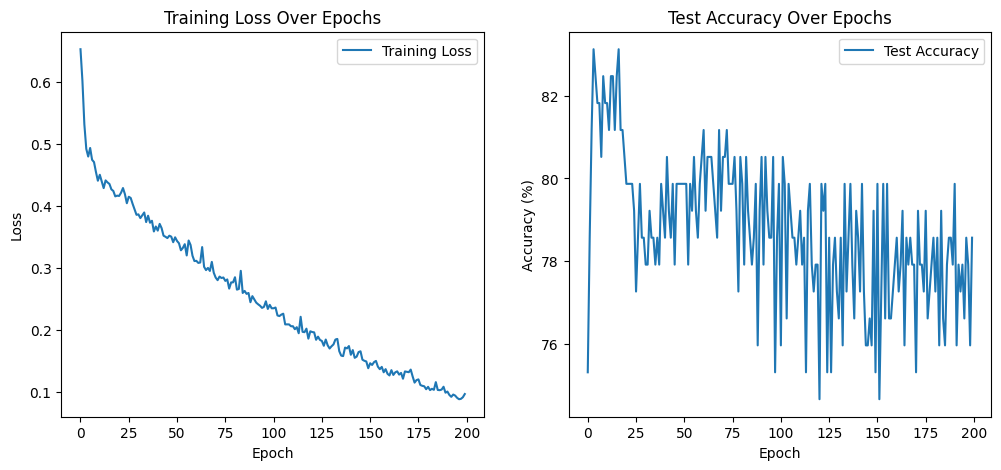

In [22]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()